In [1]:
"""
Mask R-CNN
Train on the toy Balloon dataset and implement color splash effect.
Copyright (c) 2018 Matterport, Inc.
Licensed under the MIT License (see LICENSE for details)
Written by Waleed Abdulla
------------------------------------------------------------
Usage: import the module (see Jupyter notebooks for examples), or run from
       the command line as such:
    # Train a new model starting from pre-trained COCO weights
    python3 balloon.py train --dataset=/path/to/balloon/dataset --weights=coco
    # Resume training a model that you had trained earlier
    python3 balloon.py train --dataset=/path/to/balloon/dataset --weights=last
    # Train a new model starting from ImageNet weights
    python3 balloon.py train --dataset=/path/to/balloon/dataset --weights=imagenet
    # Apply color splash to an image
    python3 balloon.py splash --weights=/path/to/weights/file.h5 --image=<URL or path to file>
    # Apply color splash to video using the last weights you trained
    python3 balloon.py splash --weights=last --video=<URL or path to file>
"""

import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2
import glob

# Root directory of the project
ROOT_DIR = os.path.abspath("../Mask_RCNN/")
print("mrcnn directory:",ROOT_DIR)

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils

# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

MODEL_DIR = os.path.join(ROOT_DIR, "logs")

#DATASET_DIR= os.path.dirname('C:/Users/Pray/Desktop/dataset1/')
DATASET_DIR= 'C:/Users/Pray/Desktop/dataset_manga/'


    

############################################################
#  Dataset
############################################################

class BalloonDataset(utils.Dataset):

    def load_balloon(self, subset):
        self.subset= subset
        
        """Load a subset of the Balloon dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("bubble", 1, "bubble")

        # Train or validation dataset?
        assert subset in ["train", "val", "test"]
        
        
        filelist= os.listdir(os.path.join(DATASET_DIR, subset, 'images'))
        for file in filelist:
            if ".png" not in file and ".jpg" not in file:
                continue
            image_path = os.path.join(DATASET_DIR, subset, 'images', file)
            try:
                image = skimage.io.imread(image_path)
            except Exception as e:
                print(image_path)
                print(e)
            height, width = image.shape[:2]
            
            #print(f'file {file}')
            self.add_image(
                "bubble",
                image_id=file,  # use file name as a unique image id
                name=file,
                path= os.path.join(DATASET_DIR, subset, 'images', file),
                width=width, height=height,
                )

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a balloon dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "bubble":
            return super(self.__class__, self).load_mask(image_id)

        fdir= DATASET_DIR + "/" + self.subset + "/masks/" + image_info["name"][:-4]
        if not (os.path.exists(fdir)):
            print(fdir)
            assert(os.path.exists(fdir))
        
        
        ids=[]
        masks= []
        for file in glob.glob(fdir + "/*.png"):
            if len(masks)!=0:
                img = cv2.imread(file, 0).astype(np.bool)
                #print(file, masks.shape, img.shape)
                masks= np.dstack((masks, img))
                ids.append(1)
            else:
                masks= cv2.imread(file, 0).astype(np.bool)
                ids.append(1)
        
              
        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        if len(masks.shape) < 3:
            masks= np.expand_dims(masks, axis=2)
        return masks, np.ones(len(ids), dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "bubble":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

mrcnn directory: C:\Programming\Bubbles\Mask_RCNN


Using TensorFlow backend.


In [2]:
############################################################
#  Configurations
############################################################


class BalloonConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    #BACKBONE = "resnet50"
    
    # Give the configuration a recognizable name
    NAME = "bubble"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + balloon

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 500

    # Skip detections with < 90% confidence
    #DETECTION_MIN_CONFIDENCE = 0.9
    
    IMAGE_RESIZE_MODE= 'crop'
    IMAGE_MIN_DIM=512
    
    MAX_GT_INSTANCES = 40
    
    

model = modellib.MaskRCNN(mode="training", model_dir=MODEL_DIR, config=BalloonConfig())

dataset_train = BalloonDataset()
dataset_train.load_balloon("train")
dataset_train.prepare()
print(len(dataset_train.image_ids), 'training images')

dataset_val = BalloonDataset()
dataset_val.load_balloon("val")
dataset_val.prepare()
print(len(dataset_val.image_ids), 'validation images')

dataset_test= BalloonDataset()
dataset_test.load_balloon("test")
dataset_test.prepare()
print(len(dataset_test.image_ids), 'testing images')

W0906 15:02:52.817266 12116 deprecation_wrapper.py:119] From c:\programming\babobot2\venv\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0906 15:02:52.839271 12116 deprecation_wrapper.py:119] From c:\programming\babobot2\venv\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0906 15:02:52.860275 12116 deprecation_wrapper.py:119] From c:\programming\babobot2\venv\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0906 15:02:52.883271 12116 deprecation_wrapper.py:119] From c:\programming\babobot2\venv\lib\site-packages\keras\backend\tensorflow_backend.py:1919: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0906 15:02:52.885272 12116 deprecation

81 training images
81 validation images
81 testing images


In [15]:
tConfig= BalloonConfig()
tConfig.IMAGE_RESIZE_MODE= 'crop'
tConfig.IMAGE_MIN_DIM=100
tConfig.IMAGE_MAX_DIM=100
tConfig.IMAGE_CHANNEL_COUNT=1
model = modellib.MaskRCNN(mode="training", model_dir=MODEL_DIR, config=tConfig)

In [16]:
#model_path = model.find_last()
#model_path= os.path.join(MODEL_DIR, "bubble20190905T2052", "mask_rcnn_bubble_0003.h5")

# Load trained weights
#print("Loading weights from ", model_path)

#model.load_weights(model_path, by_name=True)

In [17]:
model.train(dataset_train, dataset_val, 
             learning_rate=0.001, 
             epochs=15, 
             layers='all')

model.train(dataset_train, dataset_val, 
             learning_rate=0.0001, 
             epochs=30, 
             layers='all')


Starting at epoch 0. LR=0.001

Checkpoint Path: C:\Programming\Bubbles\Mask_RCNN\logs\bubble20190906T1515\mask_rcnn_bubble_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)

c:\programming\babobot2\venv\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
c:\programming\babobot2\venv\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
c:\programming\babobot2\venv\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/15


InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument: Incompatible shapes: [1,8,8,256] vs. [1,7,7,256]
	 [[{{node training_4/SGD/gradients/fpn_p4add_5/add_grad/BroadcastGradientArgs}}]]
	 [[mul_1297/_14409]]
  (1) Invalid argument: Incompatible shapes: [1,8,8,256] vs. [1,7,7,256]
	 [[{{node training_4/SGD/gradients/fpn_p4add_5/add_grad/BroadcastGradientArgs}}]]
0 successful operations.
0 derived errors ignored.

In [ ]:
model.train(dataset_train, dataset_val, 
            learning_rate=0.001, 
            epochs=80, 
            layers='3+')

model.train(dataset_train, dataset_val, 
            learning_rate=0.001, 
            epochs=100, 
            layers='4+')

model.train(dataset_train, dataset_val, 
            learning_rate=0.001, 
            epochs=120, 
            layers='5+')

model.train(dataset_train, dataset_val, 
            learning_rate=0.001, 
            epochs=140, 
            layers='heads')

In [21]:
import random
import tensorflow
import matplotlib.pyplot as plt
import random
from mrcnn import visualize

model_path= os.path.join(MODEL_DIR, "bubble20190906T0346", "mask_rcnn_bubble_0030.h5")
#model_path= model.find_last()

with tensorflow.device("/gpu:0"):
    modelI = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=BalloonConfig())
modelI.load_weights(model_path, by_name=True)   

Re-starting from epoch 30


In [38]:
class InferenceConfig(Config):
    #BACKBONE = "resnet50"
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NAME= "Inference"
    
    IMAGE_RESIZE_MODE= 'square'
    IMAGE_MIN_DIM=512
    IMAGE_MAX_DIM=512
    
    MAX_GT_INSTANCES = 40
    
    #DETECTION_MIN_CONFIDENCE = 0.99
    #DETECTION_NMS_THRESHOLD = 0.9
    
#dataset_x= dataset_val
dataset_x= dataset_train

inference_config = InferenceConfig()
image_id= random.choice(dataset_x.image_ids)

print(image_id)
info= dataset_x.image_info
for id in dataset_x.image_ids:
    if id in range(1, 20):
        True#print(id, info[id]['id'])

176


image_id  99 (2079, 690, 3) C:/Users/Pray/Desktop/dataset1\train\images\179-8.png


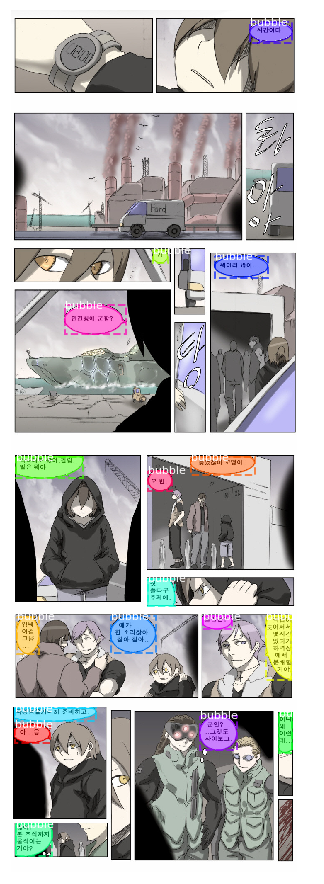

In [39]:
# Load random image and mask.
image_id = random.choice(dataset_x.image_ids)
image = dataset_x.load_image(image_id)
mask, class_ids = dataset_x.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, image.shape, dataset_x.image_reference(image_id))
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset_x.class_names)

image ID: bubble.179-8.png (99) (2079, 690, 3) C:/Users/Pray/Desktop/dataset1\train\images\179-8.png
(2079, 690, 3) <class 'imageio.core.util.Array'>
Processing 1 images
image                    shape: (2079, 690, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 2079.00000  int32
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
(2079, 690, 2)
(2,)
(2, 4) (2,)
['BG', 'bubble']
(2079, 690, 2)
(2079, 690, 3)
[0.97687554 0.9728124 ]


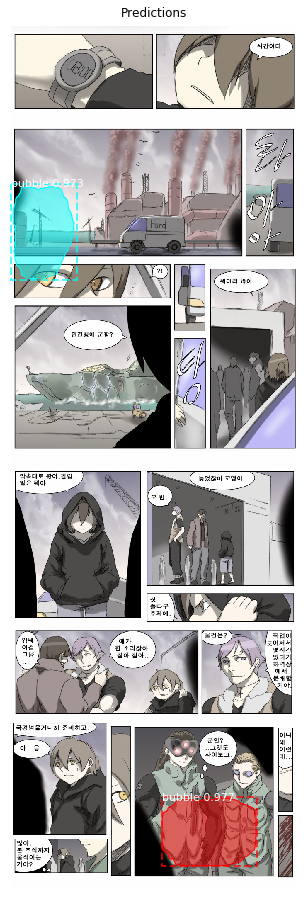

In [40]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax



#image, image_meta, gt_class_id, gt_bbox, gt_mask =   modellib.load_image_gt(dataset_x, inference_config, image_id, use_mini_mask=False)
info = dataset_x.image_info[image_id]
print("image ID: {}.{} ({}) {} {}".format(info["source"], info["id"], image_id, image.shape,
                                       dataset_x.image_reference(image_id)))


print(image.shape, type(image))
# Run object detection
results = modelI.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]

# r['masks']= np.delete(r['masks'], 3, 2)
# r['scores']= np.delete(r['scores'], 3, 0)
# r['class_ids']= np.delete(r['class_ids'], 3, 0)
# r['rois']= np.delete(r['rois'], 3, 0)

print(r['masks'].shape)
print(r['scores'].shape)
print(r['rois'].shape, r['class_ids'].shape)

visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_x.class_names, r['scores'], ax=ax,
                            title="Predictions")
print(dataset_x.class_names)
print(r['masks'].shape)
print(image.shape)
print(r['scores'])

In [16]:
import png

tst= np.ones([2040, 690, 3])
tst[:,:,0]= tst[:,:,0]*174

os.chdir("C:/Users/Pray/Desktop/dataset2/val/images/")
for k,file in enumerate(glob.glob("110-8-*.png")):
    split= file[:-4].split('-')
    
    xPos= int(split[2])
    yPos= int(split[3])
    
    image= cv2.imread(file,1)

    temp= np.copy(image)
    temp[:,:,0]= image[:,:,2]
    temp[:,:,2]= image[:,:,0]
    image= np.array(temp)
    
    #print(k, dataset_x.image_info[k]['id'], image.shape)
    #continue
    
    r= modelI.detect([image], verbose=1)[0]

    for i in range(r['masks'].shape[0]):
    #for i in range(80,432):
        for j in range(r['masks'].shape[1]):
        #for j in range(80,432):
            px= np.any(r['masks'][i,j,:])

            if not px:
                tst[yPos+i,xPos+j,:]= np.zeros([1,1,3])

png.from_array(np.uint8(tst), mode="RGB").save("C:/Users/Pray/Desktop/lol.png")

In [17]:
class InferenceConfig2(Config):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NAME= "Inference"
    
    #IMAGE_RESIZE_MODE="none"
    IMAGE_RESIZE_MODE="crop"
    IMAGE_MIN_DIM=512

image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_x, InferenceConfig(), image_id, use_mini_mask=False)

# Get input and output to classifier and mask heads.
mrcnn = modelI.run_graph([image], [
    ("proposals", modelI.keras_model.get_layer("ROI").output),
    ("probs", modelI.keras_model.get_layer("mrcnn_class").output),
    ("deltas", modelI.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", modelI.keras_model.get_layer("mrcnn_mask").output),
    ("detections", modelI.keras_model.get_layer("mrcnn_detection").output),
])



proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32
probs                    shape: (1, 1000, 2)          min:    0.00000  max:    1.00000  float32
deltas                   shape: (1, 1000, 2, 4)       min:  -10.47319  max:    8.13573  float32
masks                    shape: (1, 100, 28, 28, 2)   min:    0.19646  max:    0.93940  float32
detections               shape: (1, 100, 6)           min:    0.00000  max:    1.00000  float32


52 detections: ['bubble' 'bubble' 'bubble' 'bubble' 'bubble' 'bubble' 'bubble' 'bubble'
 'bubble' 'bubble' 'bubble' 'bubble' 'bubble' 'bubble' 'bubble' 'bubble'
 'bubble' 'bubble' 'bubble' 'bubble' 'bubble' 'bubble' 'bubble' 'bubble'
 'bubble' 'bubble' 'bubble' 'bubble' 'bubble' 'bubble' 'bubble' 'bubble'
 'bubble' 'bubble' 'bubble' 'bubble' 'bubble' 'bubble' 'bubble' 'bubble'
 'bubble' 'bubble' 'bubble' 'bubble' 'bubble' 'bubble' 'bubble' 'bubble'
 'bubble' 'bubble' 'bubble' 'bubble']


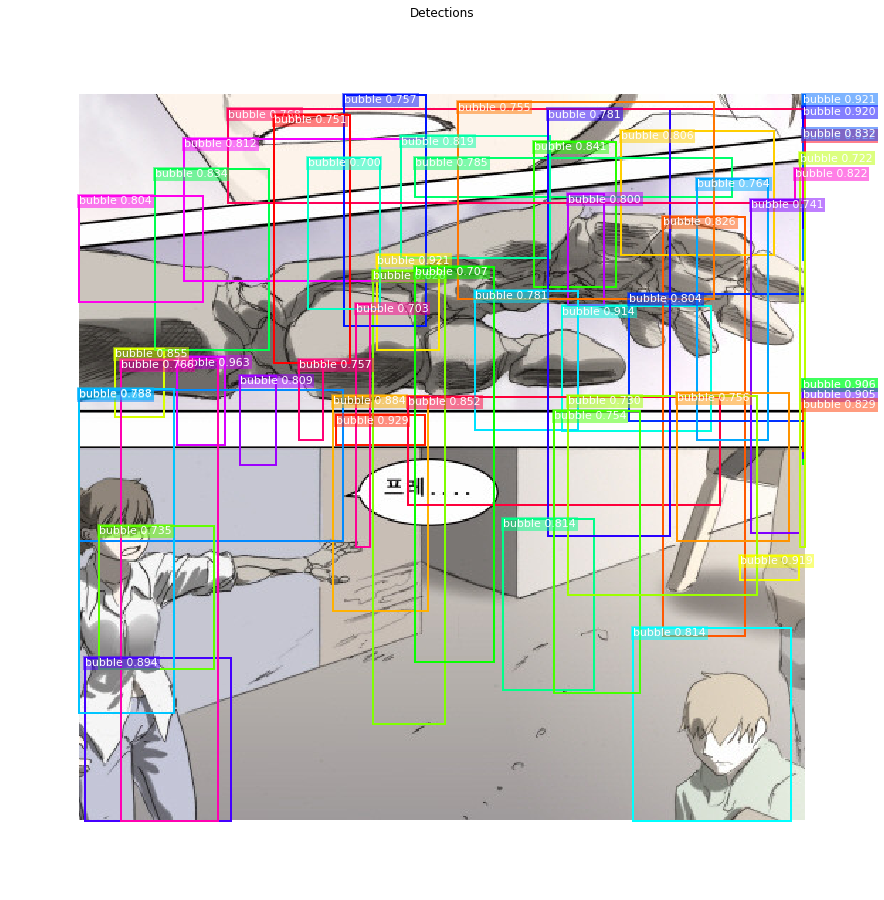

In [18]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset_x.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset_x.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=utils.denorm_boxes(detections[:, :4], image.shape[:2]),
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

In [19]:
# Proposals are in normalized coordinates. Scale them
# to image coordinates.
h, w = 700,690# config.IMAGE_SHAPE[:2]
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset_x.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

1000 Valid proposals out of 1000
257 Positive ROIs
[('BG', 743), ('bubble', 257)]


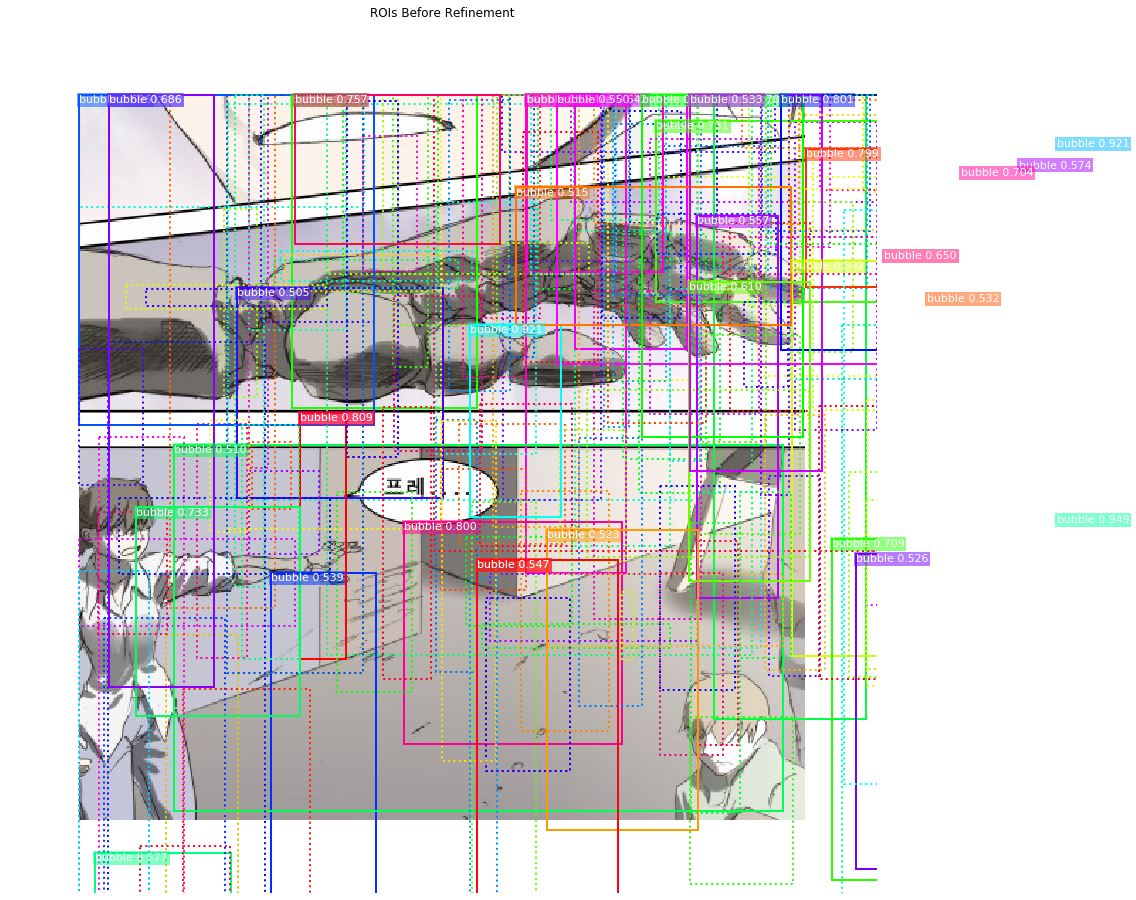

In [20]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset_x.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(image, boxes=proposals[ixs],
                     visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
                     captions=captions, title="ROIs Before Refinement",
                     ax=get_ax())

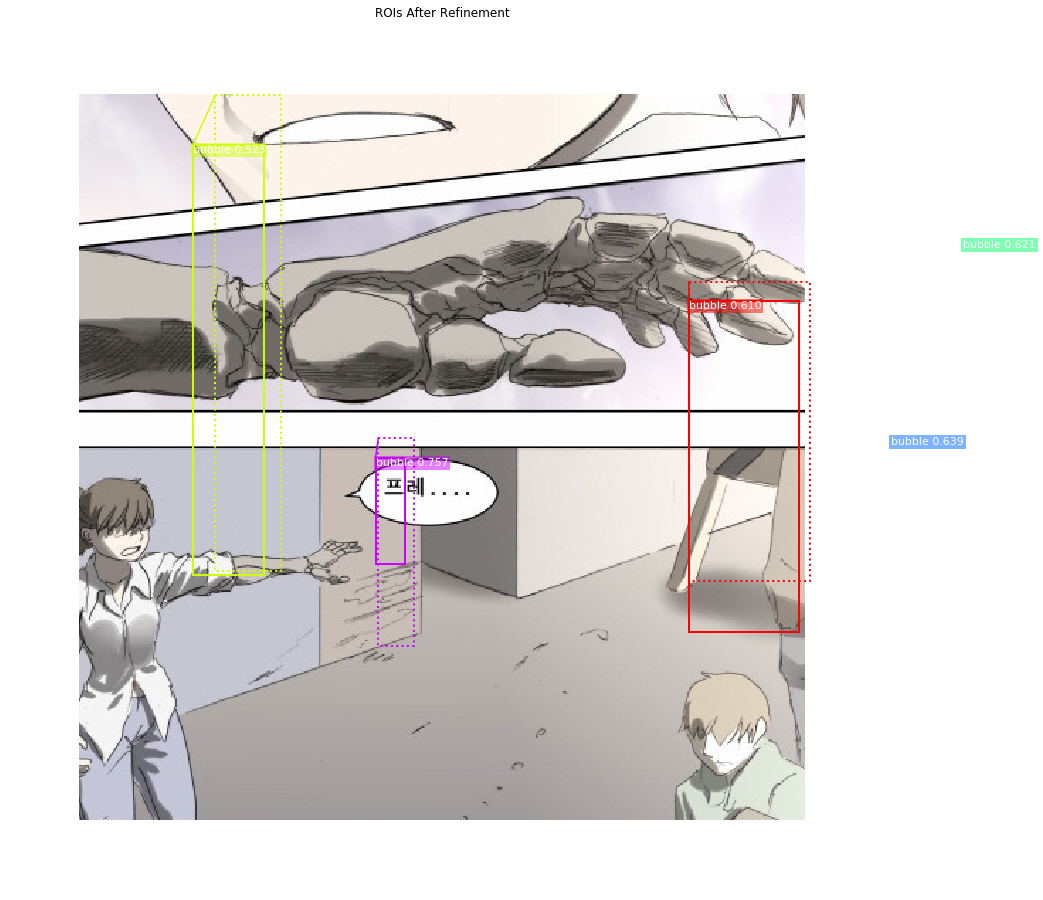

In [21]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * InferenceConfig2().BBOX_STD_DEV).astype(np.int32)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset_x.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(image, boxes=proposals[roi_positive_ixs][ids],
                     refined_boxes=refined_proposals[roi_positive_ixs][ids],
                     visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
                     captions=captions, title="ROIs After Refinement",
                     ax=get_ax())

In [22]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= InferenceConfig2().DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    InferenceConfig2().DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            InferenceConfig2().DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset_x.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

Keep 257 detections:
[  4   7  11  12  18  22  23  26  27  28  30  34  44  47  50  53  58  64
  66  69  74  75  79  80  82  96  98  99 102 103 104 106 112 115 127 128
 129 132 135 141 143 144 145 146 148 149 150 151 152 154 160 170 172 173
 178 181 186 188 192 202 204 210 213 218 221 224 225 229 241 242 244 245
 269 273 277 285 288 289 293 300 302 304 309 315 316 325 327 329 334 343
 347 349 355 359 360 362 366 369 395 403 408 411 412 417 432 439 443 447
 466 468 475 476 477 491 493 496 497 501 502 514 515 516 523 524 529 535
 538 542 545 548 549 552 553 557 560 565 568 569 573 574 575 581 589 590
 591 595 608 611 612 621 626 630 633 635 639 641 642 647 648 657 659 662
 663 664 666 668 669 671 679 682 684 692 696 700 702 708 711 716 719 721
 725 727 729 733 744 745 755 757 766 767 768 770 771 773 782 788 790 793
 795 800 808 810 813 822 829 839 840 846 847 849 860 862 869 871 874 875
 878 880 882 890 892 897 909 913 914 915 916 919 922 929 931 937 940 943
 944 947 952 953 961 964 968 9

C:\Programming\Bubbles\Mask_RCNN\mrcnn\utils.py:77: RuntimeWarning: invalid value encountered in true_divide
  iou = intersection / union
C:\Programming\Bubbles\Mask_RCNN\mrcnn\utils.py:152: RuntimeWarning: invalid value encountered in greater
  remove_ixs = np.where(iou > threshold)[0] + 1


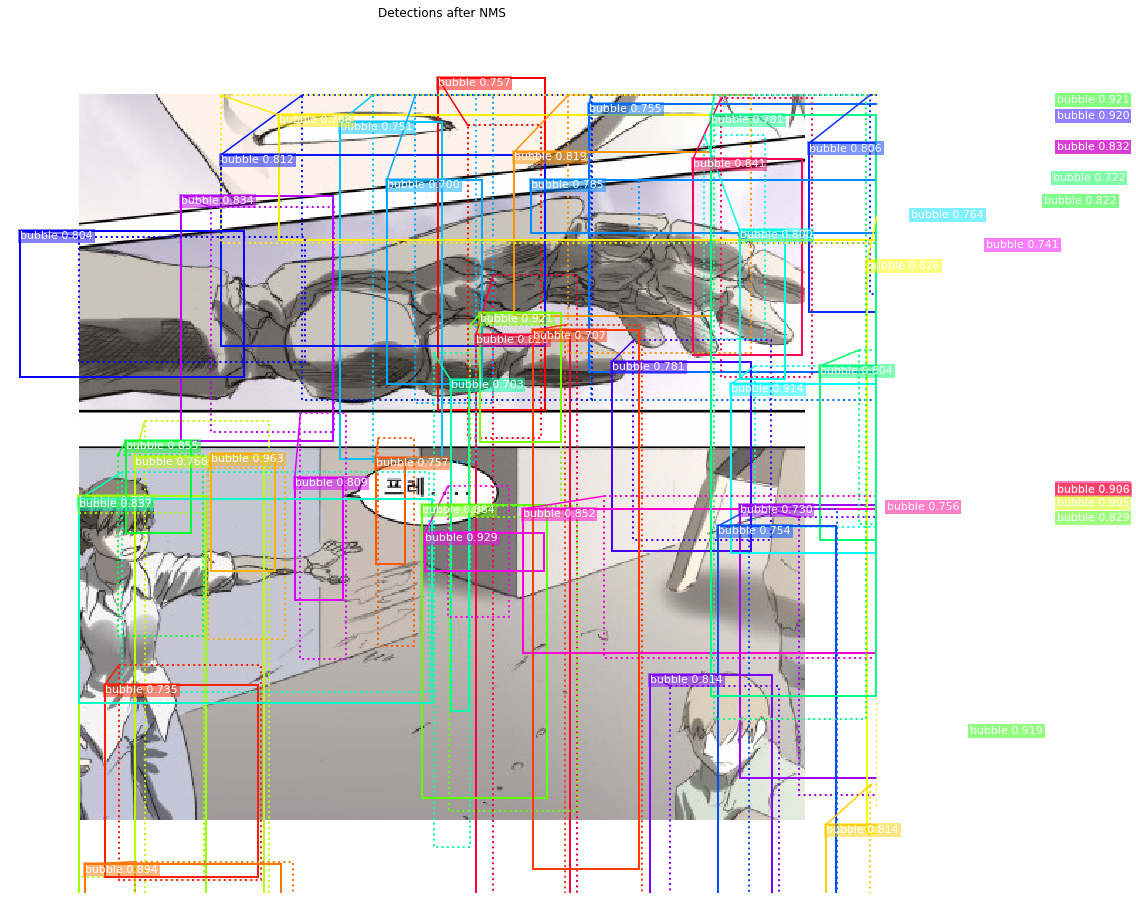

In [23]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset_x.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image, boxes=proposals[keep][ixs],
    refined_boxes=refined_proposals[keep][ixs],
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

In [24]:
modelI2 = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=BalloonConfig())
modelI2.load_weights(model_path, by_name=True)

Re-starting from epoch 3


(512, 512, 3) 116 302
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int32
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


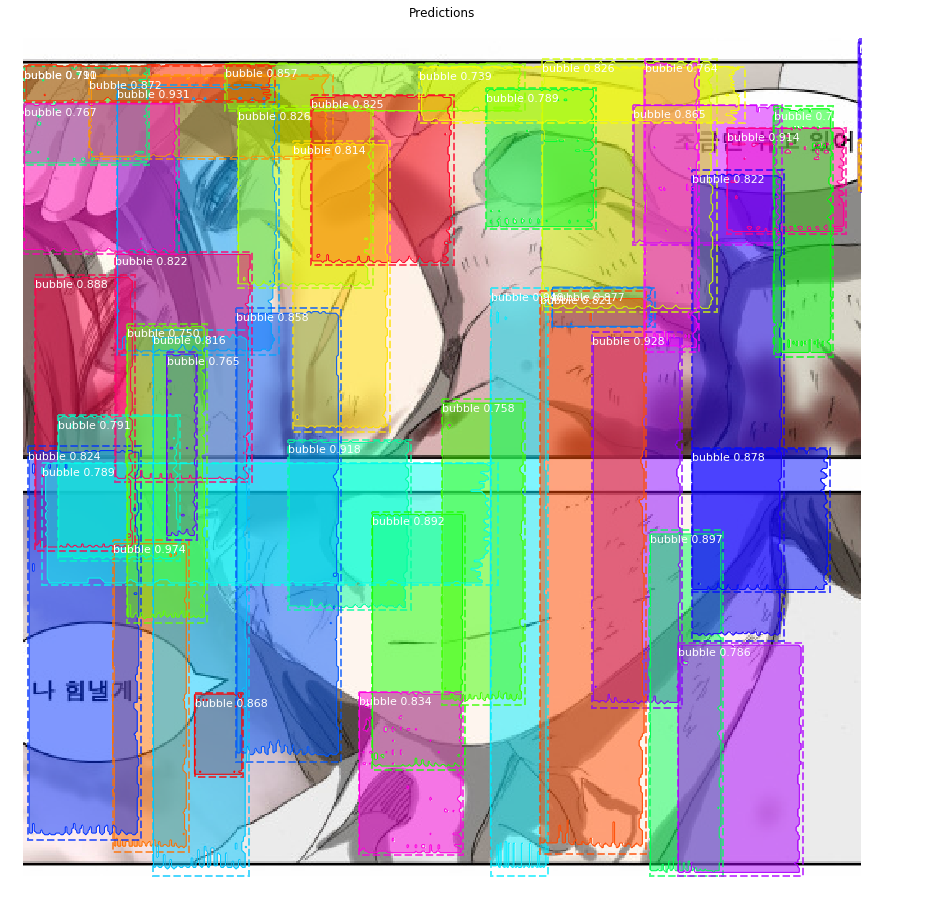

In [25]:
image_path= "F:/old_y520/docs/Korean/Knight Run/187/3.jpg"
image= cv2.imread(image_path,1)

temp= np.copy(image)
temp[:,:,0]= image[:,:,2]
temp[:,:,2]= image[:,:,0]
image= np.array(temp)

randX= random.randrange(0,image.shape[1]-512)
randY= random.randrange(0,image.shape[0]-512)

image= image[randY:(randY+512), randX:(randX+512),:]
print(image.shape, randX, randY)

# Run object detection
results = modelI.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_x.class_names, r['scores'], ax=ax,
                            title="Predictions")

In [26]:
def color_splash(image, mask):
    """Apply color splash effect.
    image: RGB image [height, width, 3]
    mask: instance segmentation mask [height, width, instance count]
    Returns result image.
    """
    # Make a grayscale copy of the image. The grayscale copy still
    # has 3 RGB channels, though.
    gray = skimage.color.gray2rgb(skimage.color.rgb2gray(image)) * 255
    #print(f'gray {gray.shape}\n{gray}')
    # Copy color pixels from the original color image where mask is set
    if mask.shape[-1] > 0:
        # We're treating all instances as one, so collapse the mask into one layer
        mask = (np.sum(mask, -1, keepdims=True) >= 1)
        #print(f'mask {mask.shape}\n{np.count_nonzero(mask)}\n{mask}')
        splash = np.where(mask, image-200, gray).astype(np.uint8)
        #print(f'splash {splash.shape}\n{splash}')
    else:
        splash = gray.astype(np.uint8)
    return splash


def detect_and_color_splash(model, image_path=None, video_path=None):
    assert image_path or video_path
    
    # Image or video?
    if image_path:
        
        # Run model detection and generate the color splash effect
        print("Running on {}".format(image_path))
        # Read image
        image = skimage.io.imread(image_path)
        if image.shape[-1] == 4:
            image = image[..., :3]
        # Detect objects
        r = model.detect([image], verbose=1)[0]
        # Color splash
        splash = color_splash(image, r['masks'])
        # Save output
        file_name = "splash_{:%Y%m%dT%H%M%S}.png".format(datetime.datetime.now())
        skimage.io.imsave(file_name, splash)
        
        
    print("Saved to ", file_name)

In [27]:
# Recreate the model in inference mode
model2 = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=os.path.join(MODEL_DIR, "test"))

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = os.path.join(MODEL_DIR, "bubble20190627T1746", "mask_rcnn_bubble_0004.h5")#model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model2.load_weights(model_path, by_name=True)

detect_and_color_splash(model2, image_path='C:\\Users\\Pray\\Desktop\\dataset2\\train\\images\\172-10-1.png')
detect_and_color_splash(model2, image_path='C:\\Users\\Pray\\Desktop\\dataset2\\train\\images\\172-10-1.png')
detect_and_color_splash(model2, image_path='C:\\Users\\Pray\\Desktop\\dataset2\\train\\images\\172-10-1.png')
detect_and_color_splash(model2, image_path='C:\\Users\\Pray\\Desktop\\dataset2\\train\\images\\172-10-1.png')
detect_and_color_splash(model2, image_path='C:\\Users\\Pray\\Desktop\\dataset2\\train\\images\\172-10-1.png')

Loading weights from  C:\Programming\Bubbles\Mask_RCNN\logs\bubble20190627T1746\mask_rcnn_bubble_0004.h5


OSError: Unable to open file (unable to open file: name = 'C:\Programming\Bubbles\Mask_RCNN\logs\bubble20190627T1746\mask_rcnn_bubble_0004.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)